## Softmax回归
Softmax回归，主要用于分类问题
> 回归问题vs分类问题
> 1. 回归是用来估计一个连续值
> 2. 分类是用来预测一个离散类别
> 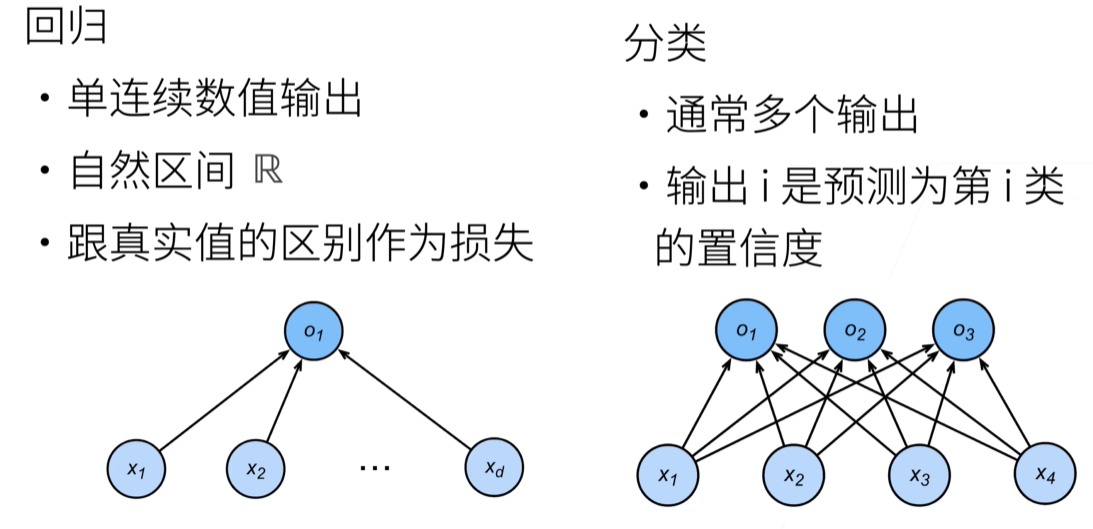
<br>
#### 从回归到多分类
- 对类别进行一位有效编码：$y = [y_1, y_2, ...,y_n]^T$
- 使用均方损失训练
- 最大值为预测：$\hat y = argmax\ o_i$
<br>
对分类来讲，我们真正关心的是**正确类的置信度要远远大于其他类的置信度**
<br>
使用softmax操作子得到每个类得预测置信度，即一组概率值，表明某个物品被识别之后属于某个类的匹配概率

$$\hat y = softmax(o)$$
$$\hat y_i = \frac{exp(o_i)}{\sum _k exp(o_k)}$$
#### 损失函数
**交叉熵**常用来衡量两个概率的区别：
$$H(p, q) = \sum _i -p_ilog(q_i)$$
将其作为损失，得：
$$l(y, \hat y) = - \sum _i y_i\log{\hat y_i} = -\log{\hat y_y}$$
> **三个常用损失函数**
> 1. L2 Loss 平方损失函数<br>
>    $l(y,y') = \frac{1}{2}(y - y')^2$
> 2. L1 Loss 绝对值损失函数<br>
>    $l(y, y') = |y - y'|$
> 3. 鲁棒损失
>    $$l(y, y') = \begin{cases}|y - y'| - \frac{1}{2}  &if |y - y'| \\  \frac{1}{2}(y - y')^2 &otherwise \end{cases} $$
>    <br>
>    即，当预测值与真实值较远时，使用绝对值损失；较近时，使用平方损失。
>    结合二者优点，可以更高地进行回归和预测}
$$


### 图像分类数据集
Fashion-MNIST服装数据集

In [1]:
%matplotlib inline
import torch
import torchvision # 计算机视觉地库
from torch.utils import data #数据处理
from torchvision import transforms #数据操作的库
from d2l import torch as d2l

d2l.use_svg_display()  # 图像使用svg显示

########## 下载数据集 ##########
## 数据预处理
trans = transforms.ToTensor() #将图像数据从PIL类型变化为32位浮点数 并处以255使得像素的数值在01之间
## 通过设置train=True设置训练集的下载 并通过trans实例进行数据转换 
mnist_train = torchvision.datasets.FashionMNIST(
    root = "../Softmax数据集", train=True, transform=trans, download=False)  
## 下载测试集
mnist_test = torchvision.datasets.FashionMNIST(
    root = "../Softmax数据集", train=False, transform=trans, download=False)

In [2]:
len(mnist_train), len(mnist_test)

(60000, 10000)

array([<AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'pullover'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'t-shirt'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'t-shirt'}>], dtype=object)

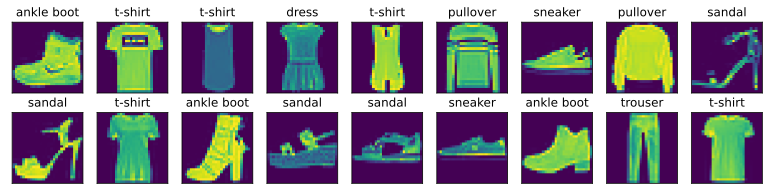

In [2]:
########## 可视化数据 ##########
def get_fashion_mnist_labels(labels):
    '''返回数据集的文本标签'''
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal',
        'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    '''绘制图像'''
    figsize = (num_cols * scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten() # 平铺
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图像为张量
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, get_fashion_mnist_labels(y))

**使用进程批量读取数据**

In [3]:
batch_size = 256
def get_dataloader_workers():
    '''使用x个进程来读取数据'''
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())
test_iter = data
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f}sec'

'3.30sec'

#### softmax手写实现

In [4]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size) #读取训练集和测试集迭代器

In [5]:
########## 参数初始化 ##########
# softmax的输入是一维向量 因此要把28*28的图像拉长
# 但拉长图像会损失一些空间信息  后期会使用卷积神经网络取优化
num_inputs = 28*28 
num_outputs = 10 # 10个类 因此模型输出为10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
########## 定义softmax操作 ##########
def softmax(X):
    X_exp = torch.exp(X) # 分子
    partition = X_exp.sum(1, keepdim=True)  # 按行求和——分母
    return X_exp / partition  # 运用了广播机制
## softmax操作验证
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0311, 0.2498, 0.1365, 0.0184, 0.5643],
         [0.0585, 0.2317, 0.0213, 0.6055, 0.0829]]),
 tensor([1.0000, 1.0000]))

In [6]:
########## 实现回归模型 ##########
def net(X):
    # X.reshape((-1, W.shape[0])) 为将图片拉伸成向量
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [8]:
### tips：已知对应的标签y 和预测之后的概率值y_hat
###       通过y来提取y_hat中的值
y = torch.tensor([0, 2]) # 第一个样本中 第1个类别是正确的预测 第二个样本中 第三个类别是正确预测
y_hat = torch.tensor([[0.1,0.3, 0.6], [0.3, 0.2, 0.5]]) # 两个样本对三个类别的预测
y_hat[[0, 1], y] #在 y_hat中  提取出 y_hat[0][y[0]]和y_hat[1][y[1]]两个元素
                 # 一般情况 [0,1]经常使用 range(len(y_hat))生成

tensor([0.1000, 0.5000])

In [9]:
########## 定义交叉熵损失函数 ##########
# def cross_entropy(y_hat, y):
#     return -torch.log(y_hat[range(len(y_hat)), y])
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)),y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [10]:
########## 预测正确率计算 ##########
def accuracy(y_hat, y):
    '''计算预测正确的数量'''
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)  # 找出每行中的最大值 作为最终的预测结果
    cmp = y_hat.type(y.dtype) == y  # 先把y_hat转化为和y一样的数据类型 再进行比较 转化为bool值
    return float(cmp.type(y.dtype).sum()) # 返回1的个数 即正确预测的个数
    
accuracy(y_hat, y) / len(y)  #预测的正确率

0.5

In [11]:
### 定义累加器Accumulator
class Accumulator:
    '''n个变量上累加'''
    def __init__(self, n):
        self.data = [0.0] * n # 生成n个元素的列表
        
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # zip函数把两个列表第一个位置元素打包、第二个位置元素打包...

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [12]:
def evaluate_accuracy(net, data_iter):
    '''计算指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模型
    metric = Accumulator(2)  # 正确预测数  预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]  #返回预测正确的比率

evaluate_accuracy(net, test_iter)

0.17

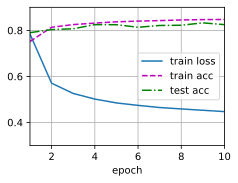

In [13]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
from IPython import display
########## 模型训练 ###########
# 训练函数
def train_epoch_ch3(net, ttain_iter, loss, updater):  # 这里updater是更新模型参数的函数
    # 将模式改为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 累加器 1训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel()) # 损失总和 准确数 样本数
    return metric[0] / metric[2], metric[1] / metric[2]

# 动画绘制图表
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                ylim=None, xscale='linear',yscale='linear',
                fmts=('-','m--','g-.','r:'),nrows=1,ncols=1,
                figsize=(3.5,2.5)): 
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows,ncols,figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0],xlabel,ylabel,xlim,ylim,xscale,yscale,legend)         
        self.X, self.Y, self.fmts = None, None, fmts
        
    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)] 
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 总的训练函数
def train_ch3(net,train_iter,test_iter,loss,num_epochs,updater):
    animator = Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0.3,0.9],       
                       legend=['train loss','train acc','test acc'])
    for epoch in range(num_epochs):  # 变量num_epochs遍数据
        train_metrics = train_epoch_ch3(net,train_iter,loss,updater) # 返回两个值，一个总损失、一个总正确率
        test_acc = evaluate_accuracy(net, test_iter) # 测试数据集上评估精度，仅返回一个值，总正确率  
        animator.add(epoch+1,train_metrics+(test_acc,)) # train_metrics+(test_acc,) 仅将两个值的正确率相加，
    train_loss, train_acc = train_metrics
    
# 小批量随即梯度下降来优化模型的损失函数
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b],lr,batch_size)

num_epochs = 10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

**使用框架实现**

In [16]:
import torch
from torch import nn
from d2l import torch as d2l

########## 数据集处理 ##########
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

########## 初始化 ##########
# pytorch中不会隐式地调整输入地形状
# 使用nn.Flatten()定义展平层  在线性层前调整网格输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights)

########## 定义损失函数 ##########
loss = nn.CrossEntropyLoss(reduction='None')  #交叉熵函数

########## 小批量随机梯度下降 ##########
lr = 0.1 # 学习率
trainer = torch.optim.SGD(net.parameters(), lr = 0.1)

########## 训练函数 ##########
num_epochs=10
d2l.train_ch3 = (net, train_iter, test_iter, loss, num_epochs, trainer)